<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

In this section import libraries that will be used throughout the analysis and modelling.

In [ ]:
!pip install scikit-surprise

In [ ]:
# Libraries for importing and loading data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Entity featurization and similarity computation
from surprise import SVD
from surprise import Reader, Dataset
from surprise.model_selection import GridSearchCV, cross_validate


<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In this section you are required to load the data from the `df_train` file into a DataFrame.

### 2.1 Brief description of the data



In [ ]:
# Load the train and test dataset with pandas
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [ ]:
# Preview train dataset
print(f'The Shape of the data is: {train.shape}')
train.head()

The Shape of the data is: (10000038, 4)


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [ ]:
# Preview test dataset
print('The Shape of the data is: ', test.shape)
test.head()

The Shape of the data is:  (5000019, 2)


,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


### Train and Test Data
Start with the most important datasets which are the train and test datasets.
Check for outliers, null values and column data types.

In [ ]:
# checking for null values
print(f'''
Train data
{train.isnull().sum()}
''')
print(f'''
Test data
{test.isnull().sum()}
''')


Train data
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


Test data
userId     0
movieId    0
dtype: int64



In [ ]:
# check train column dtype 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


In [ ]:
# check test column dtype 
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000019 entries, 0 to 5000018
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   userId   int64
 1   movieId  int64
dtypes: int64(2)
memory usage: 76.3 MB


In [ ]:
# check for null values
print(f'''
Train data
{train.nunique()}
''')
print(f'''
Test data
{test.nunique()}
''')


Train data
userId        162541
movieId        48213
rating            10
timestamp    8795101
dtype: int64


Test data
userId     162350
movieId     39643
dtype: int64



Let's visualize the rating distributions.

In [ ]:
# group by ratings for visualization
ratings_df = train.groupby(['rating']).count()

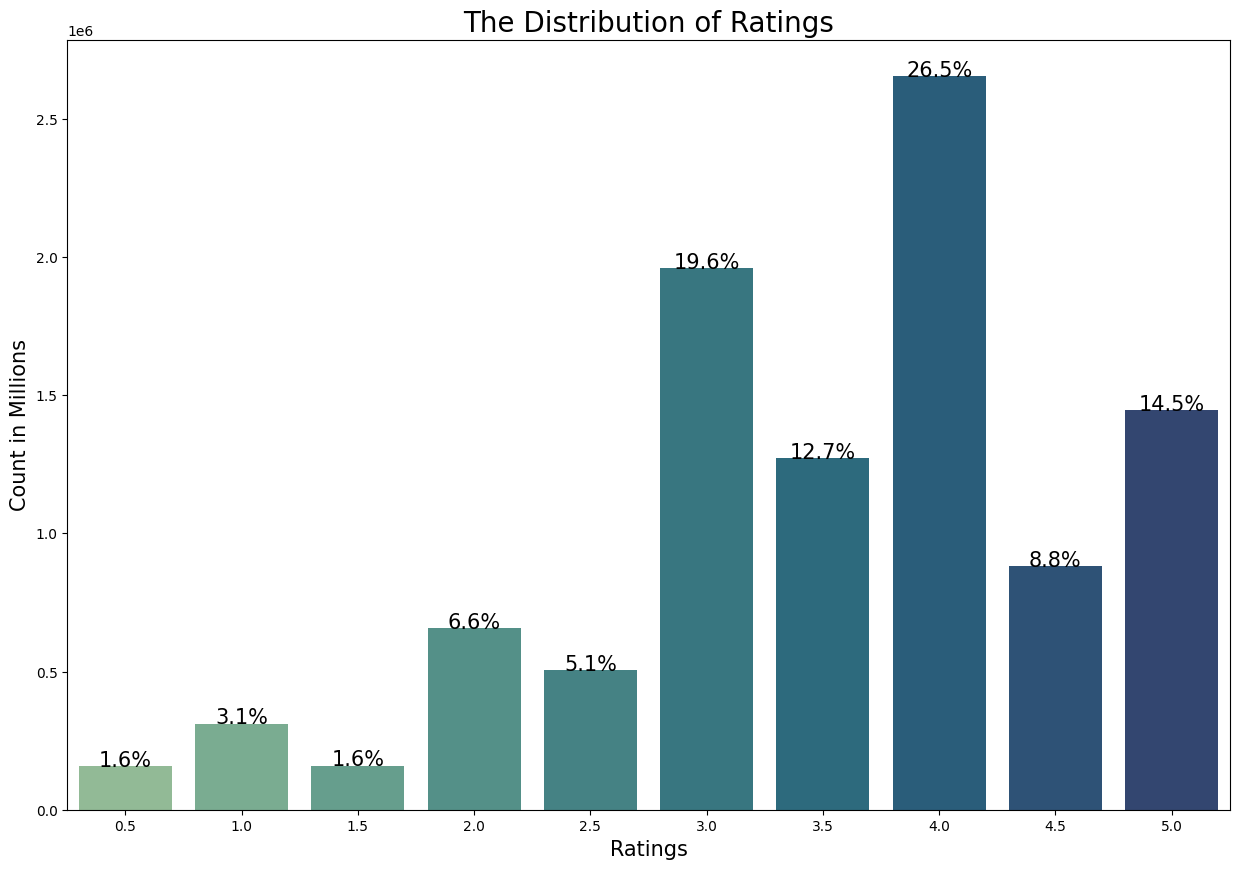

In [ ]:
#Plot showing the distribution of counts
plot = plt.figure(figsize=(15, 10))
a = sns.barplot(x=ratings_df.index,y='userId',data=ratings_df,palette='crest')
a.set_title('The Distribution of Ratings',fontsize=20)
a.set_ylabel('Count in Millions',fontsize=15)
a.set_xlabel('Ratings',fontsize=15)

#Obtaining percentages on top of bars
n_obs = [i.get_height() for i in a.patches]
total = sum(n_obs)

for i in a.patches:
    # get_x pulls left or right; get_height pushes up or down
    a.text(i.get_x()+i.get_width() / 2, i.get_height()+0.5, \
            str(round((i.get_height()/total)*100, 1))+'%', fontsize=15,
                color='black',ha='center')

plt.show()

From the above cells we can conclude that:
- There are no outliers especially on the train rating column.
- There are no null values in the two data sets.
- All the columns are numerical type.
- There are `162541` unique user IDs in the train data.
- There are `162350` unique user IDs in the test data.
- Higher ratings were given on average with `4` given the most times with a percentage of `26.5%`.

In [ ]:
del ratings_df

<a id="four"></a>
## 4. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [ ]:
# check for number of unique values in "userID" in the test dataset
test['userId'].nunique()

162350

In [ ]:
# check if there are any userIds that are in the test data and not in the train data.
test_case = test['userId'].unique()
train_case = train['userId'].unique()
print([id for id in test_case if id not in train_case])

[]


The above list is empty meaning that all the userIds in the test data are in the train data

#### Sorting of Tables

Sort both tables (train and test) by userId

In [ ]:
# Sort train dataset by userId
train.sort_values(by=['userId'], inplace= True)
train.head()

,userId,movieId,rating,timestamp
6308822,1,296,5.0,1147880044
3137042,1,27721,3.0,1147869115
2533005,1,665,5.0,1147878820
2524478,1,4308,3.0,1147868534
1946297,1,1250,4.0,1147868414


In [ ]:
# check for number of rows and columns in the train dataset
train.shape

(10000038, 4)

In [ ]:
# Sort test dataset by userId
test.sort_values(by=['userId'], inplace= True)
test.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [ ]:
# check for number of rows and columns in the test dataset
test.shape

(5000019, 2)

<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

### 5.1 Collaborative filtering

These are recommender systems that are based solely on the past interations recorded between users and items, in our case userIds and movies. These interactions are stored in **user-item interaction matrix**.

The main idea that rules collaborative method is that the past user-item interations are sufficient to detect similar users and/or similar items that make predictions possible.

Considering the EDA above, it was confirmed that all userIds in the test dataset are present in the train dataset. It was also confirmed that all movieIds in the test dataset are also present in the train dataset. Hence, predictions (movie ratings) can be made using the **collaborative filtering method**

#### Confirm shape and format of train dataset again

In [ ]:
# confirm train dataset
print('The shape of train data is: ', train.shape)
train.head()

The shape of train data is:  (10000038, 4)


,userId,movieId,rating,timestamp
6308822,1,296,5.0,1147880044
3137042,1,27721,3.0,1147869115
2533005,1,665,5.0,1147878820
2524478,1,4308,3.0,1147868534
1946297,1,1250,4.0,1147868414


#### Confirm shape and format of test dataset again

In [ ]:
# Confirm test dataset
print('The shape of test data is: ', test.shape)
test.head()

The shape of test data is:  (5000019, 2)


,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


#### Drop unwanted columns

Drop the key_words column in the train dataset because the approach to collaborative filtering
chosen **user-item**, will only require we work with the below listed columns from the train dataset:
- userId
- movieId
- rating

Also, for this approach, a python package called **surprise** will be used.
Surprise is an easy-to-use Python scikit for recommender systems.

In [ ]:
# Drop key_words column for the train dataset
ratings = train.drop(columns='timestamp')

# Instantiate a Reader object from surprise package
reader = Reader()

# Instantiate the dataset object from surprice package with the ratings table and reader object
data = Dataset.load_from_df(ratings, reader)

#### Instantiate and train an SVD model from the surprise package

The surprise package has in it different models for solving a recommender system task, one of this is the SVD model, which has chosen for this project.

#### Hyperparameter Tuning with GridSearchCV

Hyper-parameter tuning is a process of determining a set of optimal hyperparameters values for a learning algorithm.
A hyperparameter is a model argument whose value is set before the learning process begins.



In [ ]:
# uncomment and run to view the documentation of the SVD model
# help(SVD)

In [ ]:
# Instantiate an SVD model from the surprice package
svd = SVD(n_epochs=40, n_factors=1800, init_std_dev=0.005, random_state = 25, verbose=1)

# Instantiate and build the dataset with data object from surprise package
trainset = data.build_full_trainset()

# Train the SVD model  
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39


The model takes a long time to run, so **pickle** is used to save time on future runs.

In [ ]:
import pickle

model_save_path = "svd_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(svd,file)

Run the code below to load the pickled model

In [ ]:
model_load_path = "svd_model.pkl"
with open(model_load_path,'rb') as file:
    unpickled_model = pickle.load(file)

#### Making Predicitons


In [ ]:
# Extract the 'userId' column from the 'test' dataframe as a list of values
userId = test["userId"].values.tolist()

# Extract the 'movieId' column from the 'test' dataframe as a list of values
movieId = test["movieId"].values.tolist()

# Get the total number of user-movie pairs
count = len(userId)

# Initialize an empty list to store predicted ratings
rating = []

# Initialize an empty list to store unique user-movie pair identifiers
ids = []

# Loop over each user-movie pair
for i in range(count):
    
    # Predict the rating for a specific user and movie using the 'svd' model,
    # 'result' stores the predicted rating (index [3] of the returned object)
    result = svd.predict(userId[i], movieId[i])[3]

    # Append the predicted rating to the 'rating' list
    rating.append(result)

    # Create a unique identifier for the user-movie pair (in the format 'userId_movieId')
    # and append it to the 'ids' list
    ids.append(str(userId[i]) + '_' + str(movieId[i]))


In [ ]:
# Convert ids and ratings to a dataframe
test_sub_df =  pd.DataFrame({'Id': ids, 'rating': rating})
test_sub_df.head(20)

,Id,rating
0,1_2011,3.231729
1,1_4144,4.205503
2,1_5767,3.741418
3,1_6711,4.074260
4,1_7318,2.953204


In [ ]:
# check the number of rows and columns
test_sub_df.shape

(5000019, 2)

In [ ]:
# Convert dataframe to csv file
test_sub_df.to_csv('Kaggle_submission_updated_final.csv', index=False)

<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

The model achieved an RMSE score of 0.78270, indicating a relatively good performance.